In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib ipympl

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


data = 'citeseer'
policies = [
    'ens jensen greedy',
    'greedy',
    'round robin greedy',
    # 'round robin ucb'
]
ucb_beta = 3
utility_function = log_utility

n_exps = 20
n_classes = 5
init_size = 1
budget = 500

basepath = os.path.join('../../data/results', data)


utilities = np.ones((len(policies), n_exps, budget + init_size)) * -1

for p_ind, policy in enumerate(policies):
    folder = policy
    if policy.endswith('ucb'):
        folder += f' {ucb_beta}'
    
    for i in range(n_exps):
        labels = np.loadtxt(
            os.path.join(basepath, folder, f'{policy}__labels__{i + 1}.csv'), 
            dtype=int
        ).flatten() - 1

        utilities[p_ind, i, :] = log_utility(labels_to_counts(labels))
        
assert np.all(utilities != -1)

In [3]:
utilities[..., -1].mean(axis=1)

array([17.37158112, 16.77103531, 16.6567302 ])

ens jensen greedy: 17.3716
greedy: 16.7710
round robin greedy: 16.6567


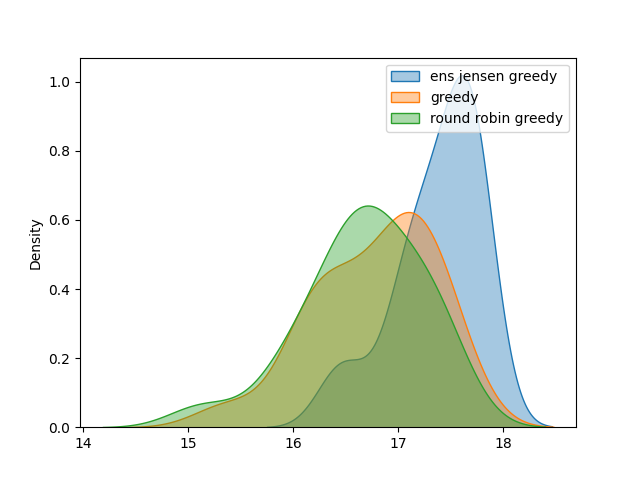

In [4]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, :, -1].mean():.4f}')
    sns.kdeplot(utilities[p_ind, :, -1], alpha=0.4, shade=True, label=policy)
    
plt.legend();

17.183154909344175 17.56000733473408
0.18842621269495297
16.503128309486453 17.038942313772242
0.26790700214289487
16.38493592167891 16.92852447163289
0.2717942749769904


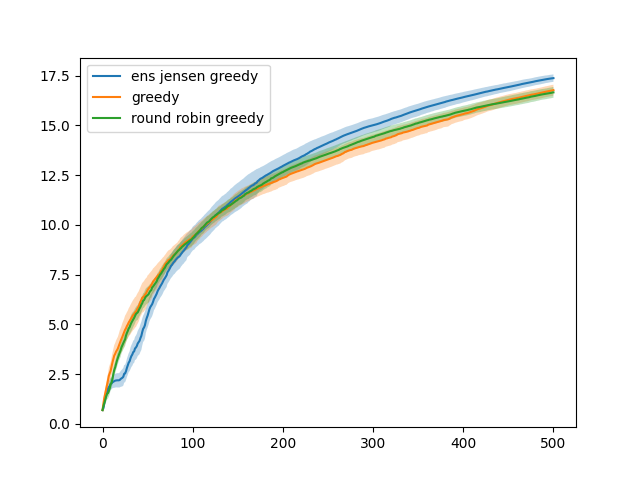

In [5]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(utilities[p_ind].mean(axis=0), label=policy)
    lower, upper = DescrStatsW(utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print((upper[-1] - lower[-1]) / 2)
    
plt.legend();